In [1]:
#import library used
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import glob
from PIL import Image
import seaborn as sns
from pathlib import Path
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import load_img,img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# This module offers classes representing filesystem paths.
positive_dir = Path('D:\\Varsity\\Thesis\\dataset\\training\\Concrete\\Positive')
negative_dir = Path('D:\\Varsity\\Thesis\\dataset\\training\\Concrete\\Negative')

In [3]:
positive_dir 

WindowsPath('D:/Varsity/Thesis/dataset/training/Concrete/Positive')

In [25]:
# Set inported image size, Batch size for CNN and label(output)
img_height = 120
img_width = 120
img_size = (img_height, img_width)
BATCH_SIZE = 64
label = ['crack', 'non-crack']

In [26]:
# Create import function for import list of image and label
# Label depends on path index
def import_data(image, label):
    filepaths = pd.Series(list(image.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    data = pd.concat([filepaths, labels], axis=1)
    return data

In [27]:
positive_data = import_data(positive_dir, label='Positive')
negative_data = import_data(negative_dir, label='Negative')

data = pd.concat(
    [positive_data, negative_data], axis=0).sample(
    frac=1.0, random_state= 88).reset_index(
    drop=True)
print(data)

                                                Filepath     Label
0      D:\Varsity\Thesis\dataset\training\Concrete\Po...  Positive
1      D:\Varsity\Thesis\dataset\training\Concrete\Po...  Positive
2      D:\Varsity\Thesis\dataset\training\Concrete\Po...  Positive
3      D:\Varsity\Thesis\dataset\training\Concrete\Ne...  Negative
4      D:\Varsity\Thesis\dataset\training\Concrete\Po...  Positive
...                                                  ...       ...
39995  D:\Varsity\Thesis\dataset\training\Concrete\Ne...  Negative
39996  D:\Varsity\Thesis\dataset\training\Concrete\Ne...  Negative
39997  D:\Varsity\Thesis\dataset\training\Concrete\Po...  Positive
39998  D:\Varsity\Thesis\dataset\training\Concrete\Ne...  Negative
39999  D:\Varsity\Thesis\dataset\training\Concrete\Ne...  Negative

[40000 rows x 2 columns]


In [28]:
data = pd.DataFrame(data)
data

,Filepath,Label
0,D:\Varsity\Thesis\dataset\training\Concrete\Po...,Positive
1,D:\Varsity\Thesis\dataset\training\Concrete\Po...,Positive
2,D:\Varsity\Thesis\dataset\training\Concrete\Po...,Positive
3,D:\Varsity\Thesis\dataset\training\Concrete\Ne...,Negative
4,D:\Varsity\Thesis\dataset\training\Concrete\Po...,Positive
...,...,...
39995,D:\Varsity\Thesis\dataset\training\Concrete\Ne...,Negative
39996,D:\Varsity\Thesis\dataset\training\Concrete\Ne...,Negative
39997,D:\Varsity\Thesis\dataset\training\Concrete\Po...,Positive
39998,D:\Varsity\Thesis\dataset\training\Concrete\Ne...,Negative


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filepath  40000 non-null  object
 1   Label     40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB


In [30]:
# Create function to convert image to array
# ***In this study, didn't use this function to import image but using tensorflow ImageDataGenerator***
def get_images_and_labels_arrays(df):
    images = []
    for datframe_name in df:
        for file in df['Filepath']:
            image = cv2.imread(file)
            image = cv2.resize(image,img_size)      
            images.append(image)
        images = np.array(images)
        
        labels = df.loc[:, 'Label']
        return images, labels


In [31]:
# Set sample size of data
num_sample = int(0.5*len(data))
num_sample

20000

In [32]:
# plt.figure(figsize=(10, 10))
# plt.subplot(2, 2, 1)
# sns.set_style('dark')
# axl = sns.countplot(data=all_data, x=all_data['Label'])
# axl.set_title("Number of Images")

In [33]:
# Separate train data and test data from sample of data (50% of data).
train_data_raw, test_data_raw = train_test_split(data.sample(num_sample, random_state= 88),
                                        train_size = 0.8,
                                        shuffle = True,
                                        random_state=88
                                        )

In [34]:
# Define validation data from 80% of test data.
val_data_raw = test_data_raw.sample(int(0.8*len(test_data_raw)), random_state = 88)

In [35]:
train_images, train_labels = get_images_and_labels_arrays(train_data_raw)

print(f'Shape of train set: {train_images.shape}')
print(f'Shape of train labels: {train_labels.shape}')

Shape of train set: (16000, 120, 120, 3)
Shape of train labels: (16000,)


In [36]:
test_images, test_labels = get_images_and_labels_arrays(test_data_raw)

print(f'Shape of test set: {test_images.shape}')
print(f'Shape of test labels: {test_labels.shape}')

Shape of test set: (4000, 120, 120, 3)
Shape of test labels: (4000,)


In [37]:
val_images, val_labels = get_images_and_labels_arrays(val_data_raw)

print(f'Shape of validation set: {val_images.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of validation set: (3200, 120, 120, 3)
Shape of validation labels: (3200,)


In [38]:
train_images.astype('float32')
val_images.astype('float32')

array([[[[211., 217., 222.],
         [207., 213., 218.],
         [205., 211., 216.],
         ...,
         [217., 224., 227.],
         [216., 223., 227.],
         [217., 222., 227.]],

        [[210., 215., 221.],
         [209., 214., 220.],
         [208., 214., 219.],
         ...,
         [215., 222., 225.],
         [214., 220., 225.],
         [214., 220., 225.]],

        [[205., 211., 216.],
         [208., 214., 219.],
         [209., 215., 220.],
         ...,
         [211., 217., 220.],
         [212., 219., 223.],
         [214., 220., 225.]],

        ...,

        [[195., 203., 206.],
         [196., 204., 206.],
         [194., 201., 204.],
         ...,
         [200., 206., 211.],
         [199., 205., 210.],
         [199., 205., 210.]],

        [[194., 200., 206.],
         [199., 205., 211.],
         [196., 202., 208.],
         ...,
         [203., 208., 212.],
         [199., 205., 210.],
         [197., 203., 208.]],

        [[194., 199., 208.],
       

In [39]:
X_train = train_data_raw.iloc[:,0]
X_test = test_data_raw.iloc[:,0]
y_train = test_data_raw.iloc[:,1]
y_test = test_data_raw.iloc[:,1]

In [40]:
# Define ImageDataDeneratior with rescale 1./ amount number of color (255).
img_datagen = ImageDataGenerator(rescale=1./255)

# Crate train dataframe wiht ImageDataGenerator.flow_from_dataframe
train_data = img_datagen.flow_from_dataframe(
    train_data_raw, # DataFrame used for create.
    x_col='Filepath', # Access filepath to import image data to DataFrame.
    y_col='Label', # Setting Label as y_col.
    target_size=img_size,
    color_mode='rgb',
    class_mode='binary', # Becasue of label has Positive and Negative, On other hand it's binary. 
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=88 # Random seed
)


Found 16000 validated image filenames belonging to 2 classes.


In [41]:
# Crate validation dataframe with ImageDataGenerator.flow_from_dataframe
val_data = img_datagen.flow_from_dataframe(
    val_data_raw, # DataFrame used for create.
    x_col='Filepath', # Access filepath to import image data to DataFrame.
    y_col='Label', # Setting Label as y_col.
    target_size=img_size,
    color_mode='rgb',
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=88
)

Found 3200 validated image filenames belonging to 2 classes.


In [42]:
# Crate test dataframe with ImageDataGenerator.flow_from_dataframe
test_data = img_datagen.flow_from_dataframe(
    test_data_raw, # DataFrame used for create.
    x_col='Filepath', # Access filepath to import image data to DataFrame.
    y_col='Label', # Setting Label as y_col.
    target_size=img_size,
    color_mode='rgb',
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=88
)

Found 4000 validated image filenames belonging to 2 classes.


In [43]:
# Create CNN : Sequential model with tf.keras
model = Sequential()
model.add(tf.keras.Input(shape=(120,120, 3))) # Define input shape height 120 and width 120 with 3 chanel of color.
# The first layer, Using 32 layer of feature with kernel size 2x2 and Activation function is ReLu.
# Using ReLu cause of 2 class of output. So, if it less than 2, it'll be 0.
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(2, 2), activation='relu'))
# Using maxpool in pooling stage.
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(2, 2), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(2, 2), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
# GlobalAveragePooling2D() applies average pooling on the spatial dimensions until each spatial dimension is one,
# and leaves other dimensions unchanged. 
model.add(tf.keras.layers.GlobalAveragePooling2D())
# For classification, Using sigmoid beacuse it have only 2 classes(output).
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


In [44]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 119, 119, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        4128      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0

In [45]:
# Compile model with Adam optimizer at learning rate 0.001. binary crossentropy as loss function.
# Using accuracy for performance metric.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define history val to keep log.
# fitting model with train data and use val_data as validation data.
# Separate batch size to reduce memory usage and time in training.
history = model.fit(train_data,
              batch_size=BATCH_SIZE,
              epochs=20,
              validation_data=val_data,
              shuffle = True)

Epoch 1/20
250/250 [==============================] - 345s 1s/step - loss: 0.6803 - accuracy: 0.6541 - val_loss: 0.6450 - val_accuracy: 0.7862
Epoch 2/20
250/250 [==============================] - 201s 803ms/step - loss: 0.5758 - accuracy: 0.7951 - val_loss: 0.5080 - val_accuracy: 0.8238
Epoch 3/20
250/250 [==============================] - 201s 803ms/step - loss: 0.4503 - accuracy: 0.8606 - val_loss: 0.3896 - val_accuracy: 0.8984
Epoch 4/20
250/250 [==============================] - 182s 727ms/step - loss: 0.3407 - accuracy: 0.9124 - val_loss: 0.2897 - val_accuracy: 0.9278
Epoch 5/20
250/250 [==============================] - 190s 759ms/step - loss: 0.2599 - accuracy: 0.9367 - val_loss: 0.2235 - val_accuracy: 0.9466
Epoch 6/20
250/250 [==============================] - 180s 720ms/step - loss: 0.2095 - accuracy: 0.9471 - val_loss: 0.1849 - val_accuracy: 0.9563
Epoch 7/20
250/250 [==============================] - 183s 731ms/step - loss: 0.1795 - accuracy: 0.9544 - val_loss: 0.1614 - va

63/63 [==============================] - 12s 195ms/step


C:\Users\Noman\AppData\Local\Temp\ipykernel_12364\1577403411.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))


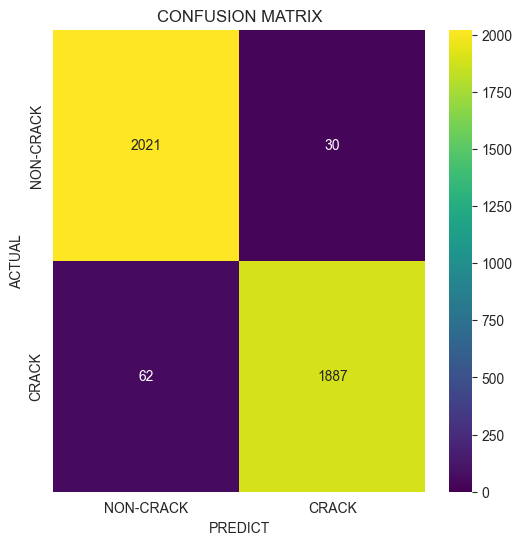

<Figure size 640x480 with 0 Axes>

In [53]:
# Using test data for prediction.
# After define y prediction(y_pred), evaluating performance with confusion matrix.
y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
cm = confusion_matrix(test_data.labels, y_pred)
# Plot confusion matrix.
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True,fmt= 'g', vmin=0, cmap='viridis')
plt.xticks(ticks=np.arange(2) + 0.5, labels=["NON-CRACK", "CRACK"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["NON-CRACK", "CRACK"])
plt.xlabel("PREDICT")
plt.ylabel("ACTUAL")
plt.title("CONFUSION MATRIX")
plt.show()
plt.savefig('Confusion Matrix VGG16.png')

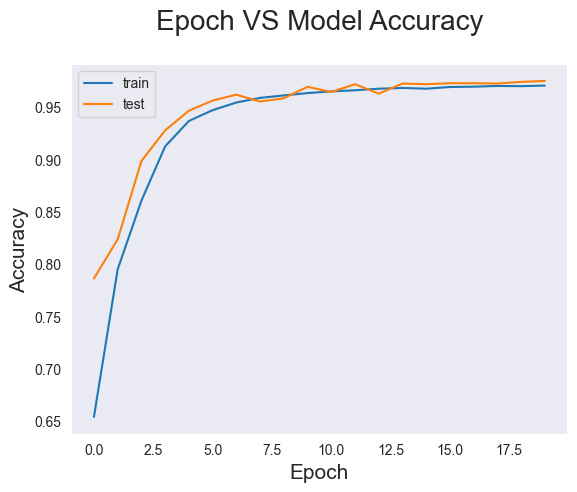

In [63]:
# This graph show Accuracy overtime from the begining to ending of training.
plt.subplot(1,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Epoch VS Model Accuracy', size=20, pad=25)
plt.ylabel('Accuracy', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Epoch VS Model Accuracy VGG16.png')

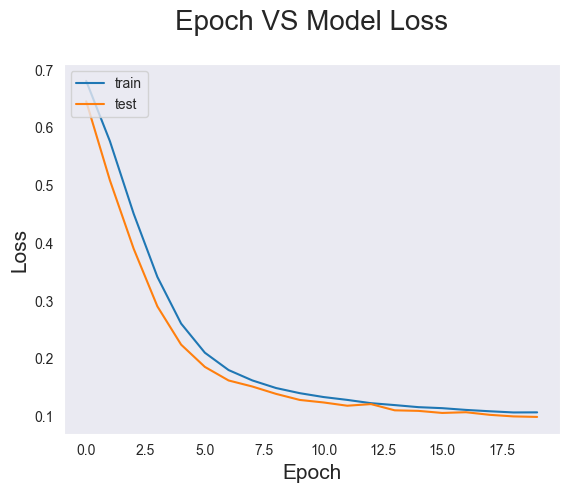

<Figure size 640x480 with 0 Axes>

In [64]:
plt.subplot(1,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Epoch VS Model Loss', size=20, pad=25)
plt.ylabel('Loss', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('Epoch VS Model Loss in VGG16.png')

In [49]:
print(classification_report(test_data.labels,y_pred, target_names=label))

              precision    recall  f1-score   support

       crack       0.97      0.99      0.98      2051
   non-crack       0.98      0.97      0.98      1949

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000



C:\Users\Noman\AppData\Local\Temp\ipykernel_12364\430107559.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = samples[1].astype(np.int)


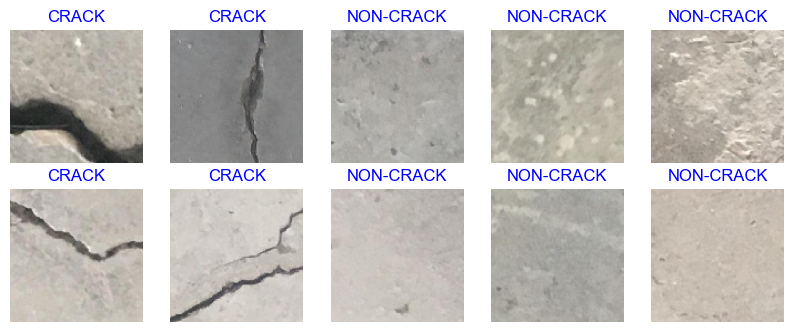

In [50]:
samples = test_data.next()
labels = samples[1].astype(np.int)

plt.figure(figsize=(10,10))

for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.imshow(samples[0][i])
    plt.axis('off')
    plt.title(("CRACK" if y_pred[i] == 1 else "NON-CRACK"), color=("blue" if labels[i] == y_pred[i] else "red"))